In [5]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 10 13:17:46 2022

@author: BetzLab-Admin
"""

import sys
sys.path.append('../../lib')
from time import sleep
#from pipython import GCSDevice
#from pipython import pitools
from scipy.signal import fftconvolve
#import keyboard
from math import cos, sin, pi
import numpy as np
#from pycromanager import Core,Studio
from detection_methods import trajectory_corr, trajectory_gauss, trajectory_mean,trajectory_till, trajectory_till_stepwise,most_common_value, compare_trajectories, plt_accuracy_results, trajectory_polar_comparison,save_result, load_result, trajectory_polar_comparison,find_ideal_R
from detection_methods import make_test_trajectory as make_movie
import matplotlib.pyplot as plt
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage import label
#from microscope_functions import snap_image, move_large_stage, calibration_matrix, center_crop, fullscreen, move_stage, beat_to_center, center_object, optimal_z_position
import csv
import random
import os
from tqdm import tqdm

import json
#from pipython.datarectools import getservotime

#core.set_exposure(0.5)##sets the cameras exposure time for snapshots to half a milisecond

C:\Users\jschulz\AppData\Local\Temp\ipykernel_18648\1441607444.py:21: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter


In [6]:
experiment_folder=r'\\134.76.13.158\betzlab\Julian\fixed_beat_experiments\location_validation_experiments'
experiment_name='exposure_200'

In [3]:


# Assuming that the trajectory functions are defined:
# trajectory_corr(), trajectory_gauss(), trajectory_mean(), trajectory_till(), trajectory_till_stepwise()

import os
import numpy as np

def compute_trajectories_for_datapoint(datapoint_folder):
    # Load the movie
    movie = np.load(os.path.join(datapoint_folder, 'movie.npy'))
    
    # Define trajectory methods and filenames
    trajectory_methods = [trajectory_corr, trajectory_gauss, trajectory_mean, trajectory_till, trajectory_till_stepwise]
    file_names = ['tra_corr.npy', 'tra_gauss.npy', 'tra_mean.npy', 'tra_till.npy', 'tra_till_stepwise.npy']
    
    # Iterate over each method and file name
    for method, file_name in zip(trajectory_methods, file_names):
        file_path = os.path.join(datapoint_folder, file_name)
        
        # Only calculate and save the trajectory if it doesn't already exist
        if not os.path.exists(file_path):
            trajectory = method(movie)
            np.save(file_path, trajectory)



# Loop over all data points and compute trajectories
for i in range(50):
    if os.path.exists(os.path.join(experiment_folder, experiment_name, 'datapoint_' + str(i))):
        datapoint_name = 'datapoint_' + str(i)
        datapoint_folder = os.path.join(experiment_folder, experiment_name, datapoint_name)
        
        compute_trajectories_for_datapoint(datapoint_folder)

In [4]:

# Create empty lists to store concatenated trajectories and points
all_tra_corr = []
all_tra_gauss = []
all_tra_mean = []
all_tra_till = []
all_tra_till_stepwise = []
all_points = []

# Function to load and append trajectories and points for a given datapoint
def load_and_append_trajectories_and_points(datapoint_folder):
    all_tra_corr.append(np.load(os.path.join(datapoint_folder, 'tra_corr.npy')))
    all_tra_gauss.append(np.load(os.path.join(datapoint_folder, 'tra_gauss.npy')))
    all_tra_mean.append(np.load(os.path.join(datapoint_folder, 'tra_mean.npy')))
    all_tra_till.append(np.load(os.path.join(datapoint_folder, 'tra_till.npy')))
    all_tra_till_stepwise.append(np.load(os.path.join(datapoint_folder, 'tra_till_stepwise.npy')))
    all_points.append(np.load(os.path.join(datapoint_folder, 'points.npy')))

# Loop over all data points and load trajectories and points
for i in range(50):
    if os.path.exists(os.path.join(experiment_folder, experiment_name, 'datapoint_' + str(i))):
        datapoint_name = 'datapoint_' + str(i)
        datapoint_folder = os.path.join(experiment_folder, experiment_name, datapoint_name)
        
        load_and_append_trajectories_and_points(datapoint_folder)

# Convert lists to numpy arrays
all_tra_corr = np.concatenate(all_tra_corr, axis=0)
all_tra_gauss = np.concatenate(all_tra_gauss, axis=0)
all_tra_mean = np.concatenate(all_tra_mean, axis=0)
all_tra_till = np.concatenate(all_tra_till, axis=0)
all_tra_till_stepwise = np.concatenate(all_tra_till_stepwise, axis=0)
all_points = np.concatenate(all_points, axis=0)

# Save the concatenated numpy arrays
np.save(os.path.join(experiment_folder, experiment_name, 'all_tra_corr.npy'), all_tra_corr)
np.save(os.path.join(experiment_folder, experiment_name, 'all_tra_gauss.npy'), all_tra_gauss)
np.save(os.path.join(experiment_folder, experiment_name, 'all_tra_mean.npy'), all_tra_mean)
np.save(os.path.join(experiment_folder, experiment_name, 'all_tra_till.npy'), all_tra_till)
np.save(os.path.join(experiment_folder, experiment_name, 'all_tra_till_stepwise.npy'), all_tra_till_stepwise)
np.save(os.path.join(experiment_folder, experiment_name, 'all_points.npy'), all_points)


In [7]:
# Load the concatenated numpy arrays
all_tra_corr = np.load(os.path.join(experiment_folder, experiment_name, 'all_tra_corr.npy'))
all_tra_gauss = np.load(os.path.join(experiment_folder, experiment_name, 'all_tra_gauss.npy'))
all_tra_mean = np.load(os.path.join(experiment_folder, experiment_name, 'all_tra_mean.npy'))
all_tra_till = np.load(os.path.join(experiment_folder, experiment_name, 'all_tra_till.npy'))
all_tra_till_stepwise = np.load(os.path.join(experiment_folder, experiment_name, 'all_tra_till_stepwise.npy'))
all_points = np.load(os.path.join(experiment_folder, experiment_name, 'all_points.npy'))


In [8]:
def correct_trajectory_with_gauss(all_tra_corr, all_tra_gauss):
    """
    Replace problematic steps in the all_tra_corr trajectory with those from all_tra_gauss.
    
    Args:
    - all_tra_corr (numpy.ndarray): Original trajectory.
    - all_tra_gauss (numpy.ndarray): Gaussian trajectory.
    
    Returns:
    - corrected_trajectory (numpy.ndarray): Corrected trajectory.
    """
    # Calculate steps for both trajectories
    corr_steps = np.diff(all_tra_corr, axis=0)
    gauss_steps = np.diff(all_tra_gauss, axis=0)
    
    # Replace steps in all_tra_corr that have a size of 0 or more than 7 with steps from all_tra_gauss
    lengths = np.linalg.norm(corr_steps, axis=1)
    mask = (lengths == 0) | (lengths > 7)
    corr_steps[mask] = gauss_steps[mask]
    
    # Convert modified steps back into a trajectory
    corrected_trajectory = np.vstack([all_tra_corr[0], all_tra_corr[0] + np.cumsum(corr_steps, axis=0)])
    
    return corrected_trajectory

# Test
corrected_traj = correct_trajectory_with_gauss(all_tra_corr, all_tra_gauss)


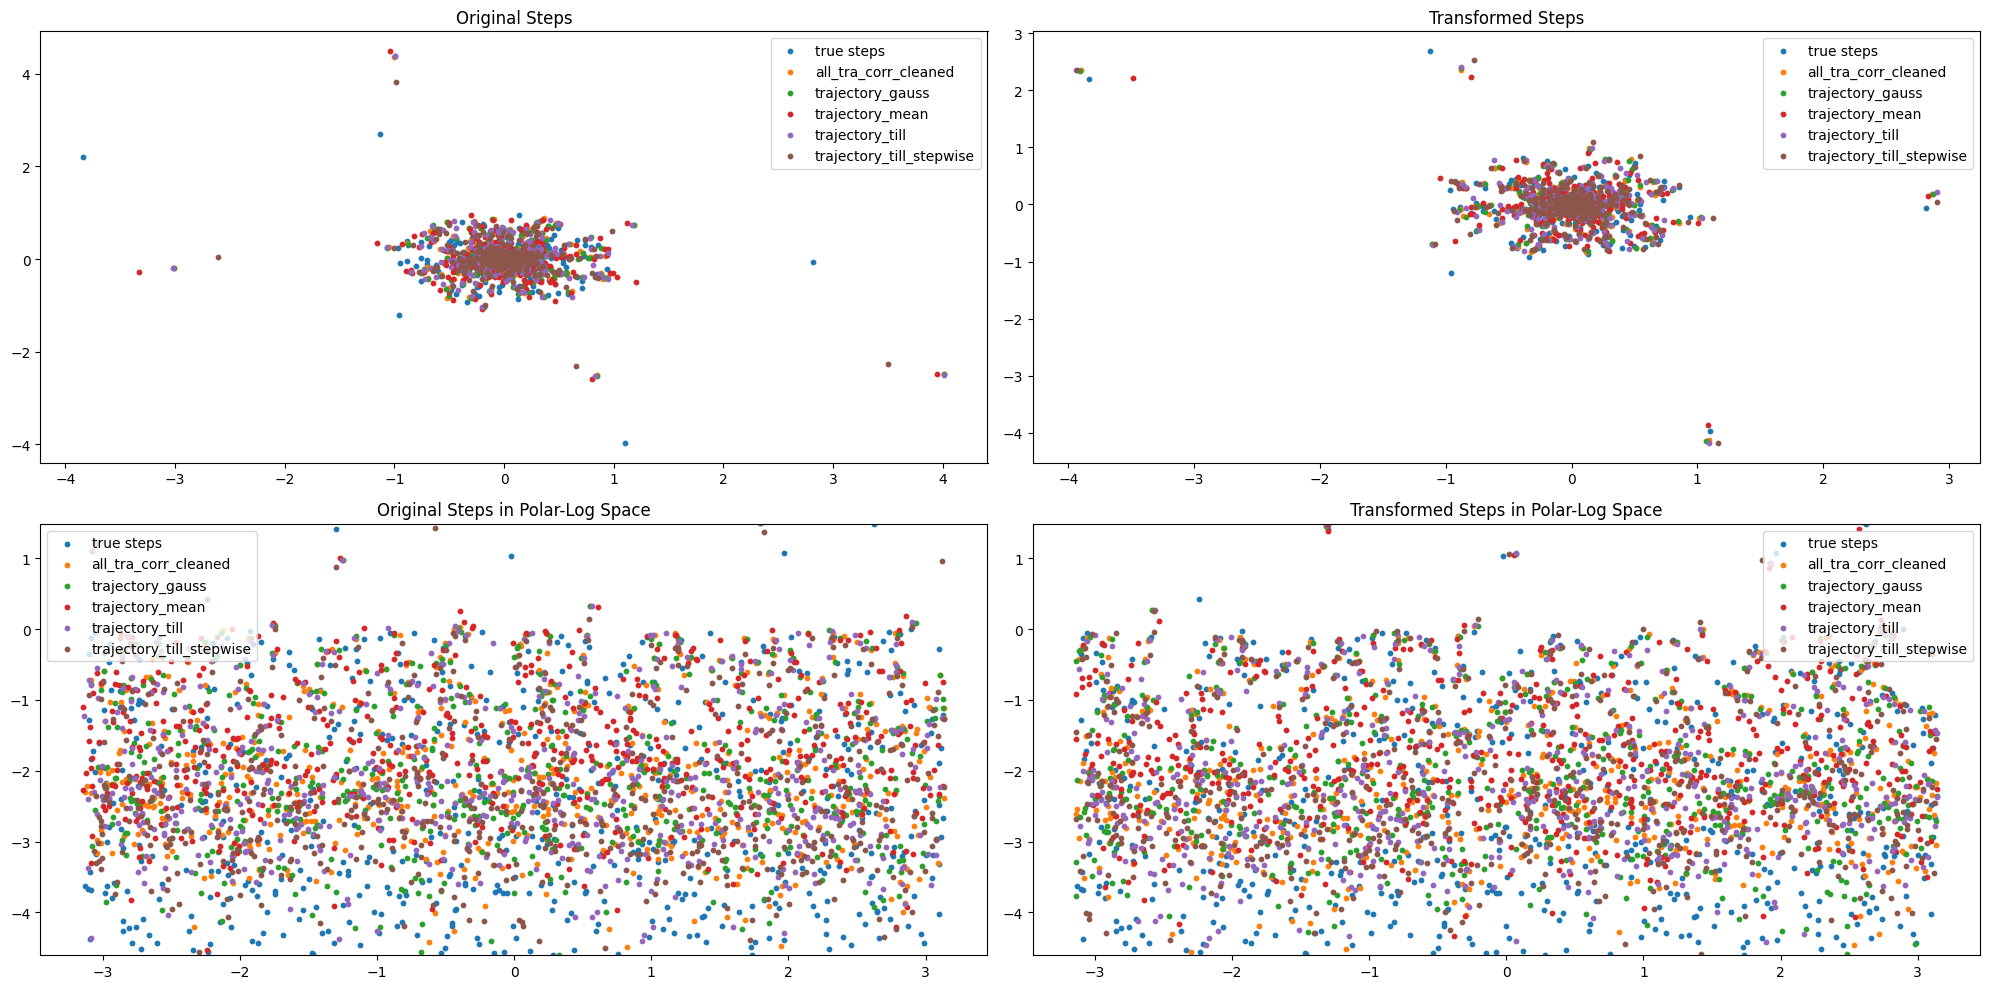

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define function to compute transformation matrix
def compute_transformation_matrix(source, target):
    return np.linalg.lstsq(source, target, rcond=None)[0]

# Define function to convert to polar coordinates
def cartesian_to_polar(coords):
    r = np.sqrt(coords[:, 0]**2 + coords[:, 1]**2)
    theta = np.arctan2(coords[:, 1], coords[:, 0])
    return np.column_stack((r, theta))

# Calculate steps
def calculate_steps(data):
    return np.diff(data, axis=0)

def reconstruct_trajecotry(steps):
    """
    Reconstruct the original data from the steps, assuming the starting point is [0,0].

    Parameters:
    - steps: Differences between consecutive points.

    Returns:
    - Original data reconstructed from the steps.
    """
    starting_point = np.array([0, 0])
    return np.vstack([starting_point, np.cumsum(steps, axis=0) + starting_point])


# Load your main data
all_steps = calculate_steps(all_points)

# Trajectories list
trajectories = [corrected_traj, all_tra_gauss, all_tra_mean, all_tra_till, all_tra_till_stepwise]
labels = ["all_tra_corr_cleaned", "trajectory_gauss", "trajectory_mean", "trajectory_till", "trajectory_till_stepwise"]
transformed_trajectories = []

# Compute transformation matrix for each trajectory and apply it
for tra in trajectories:
    matrix = compute_transformation_matrix(calculate_steps(tra), all_steps)
    transformed_trajectories.append(calculate_steps(tra) @ matrix)

# Convert steps to polar coordinates and take the log of the length
transformed_trajectories_polar = [cartesian_to_polar(tra) for tra in transformed_trajectories]
points_polar_steps = cartesian_to_polar(all_steps)

# Define ylims for log plots
ylim_min = np.min(np.log(points_polar_steps[:, 0] + 1e-10))
ylim_max = np.max(np.log(points_polar_steps[:, 0] + 1e-10))

# Plotting
plt.figure(figsize=(20, 10))

# Original steps in real space
plt.subplot(2, 2, 1)
plt.scatter(all_steps[:, 0], all_steps[:, 1], label='true steps', s=10)
for tra, label in zip(trajectories, labels):
    plt.scatter(calculate_steps(tra)[:, 0], calculate_steps(tra)[:, 1], label=label, s=10)
plt.legend()
plt.title('Original Steps')

# Transformed steps in real space
plt.subplot(2, 2, 2)
plt.scatter(all_steps[:, 0], all_steps[:, 1], label='true steps', s=10)
for tra, label in zip(transformed_trajectories, labels):
    plt.scatter(tra[:, 0], tra[:, 1], label=label, s=10)
plt.legend()
plt.title('Transformed Steps')

# Original steps in polar-log space
plt.subplot(2, 2, 3)
plt.scatter(points_polar_steps[:, 1], np.log(points_polar_steps[:, 0] + 1e-10), label='true steps', s=10)
for tra, label in zip(trajectories, labels):
    tra_polar = cartesian_to_polar(calculate_steps(tra))
    plt.scatter(tra_polar[:, 1], np.log(tra_polar[:, 0] + 1e-10), label=label, s=10)
plt.ylim(ylim_min, ylim_max)
plt.legend()
plt.title('Original Steps in Polar-Log Space')

# Transformed steps in polar-log space
plt.subplot(2, 2, 4)
plt.scatter(points_polar_steps[:, 1], np.log(points_polar_steps[:, 0] + 1e-10), label='true steps', s=10)
for tra, label in zip(transformed_trajectories_polar, labels):
    plt.scatter(tra[:, 1], np.log(tra[:, 0] + 1e-10), label=label, s=10)
plt.ylim(ylim_min, ylim_max)
plt.legend()
plt.title('Transformed Steps in Polar-Log Space')

plt.tight_layout()
plt.show()


In [10]:
results_list=[]
# Loop through each transformed trajectory
for tra, label in zip(transformed_trajectories, labels):
    Stepsize_bins, stepsize_bin_accuracies, sigma_stepsize_bin_accuracies = compare_trajectories(reconstruct_trajecotry(tra), all_points)
    
    results = {
        "Stepsize_bins": Stepsize_bins,
        "stepsize_bin_accuracies": stepsize_bin_accuracies,
        "sigma_stepsize_bin_accuracies": sigma_stepsize_bin_accuracies,
        "test_traj": all_points,
        "calc_traj": reconstruct_trajecotry(tra),
        "name": label
    }
    
    results_list.append(results)

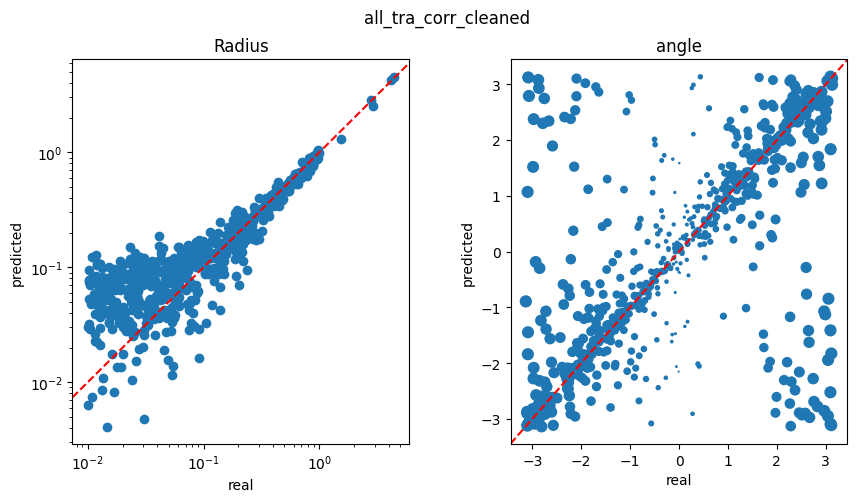

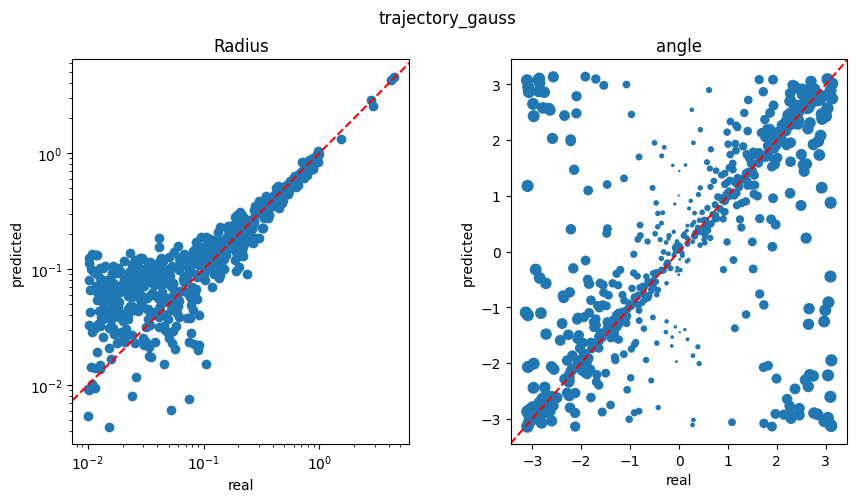

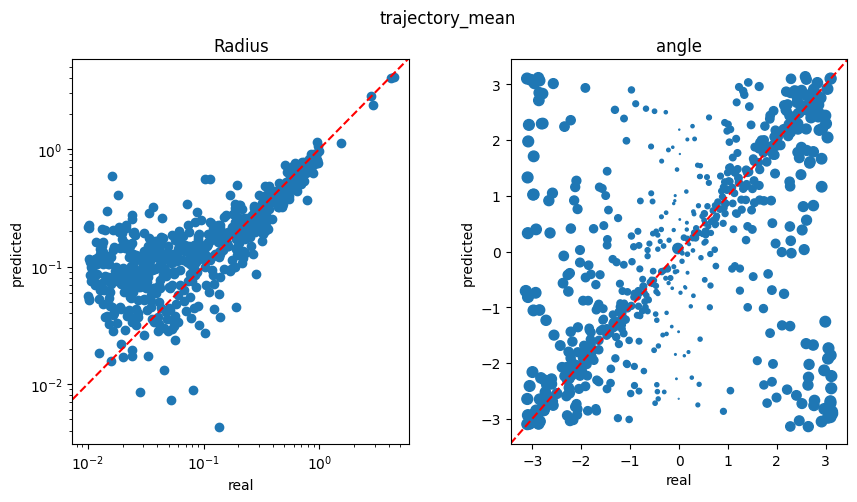

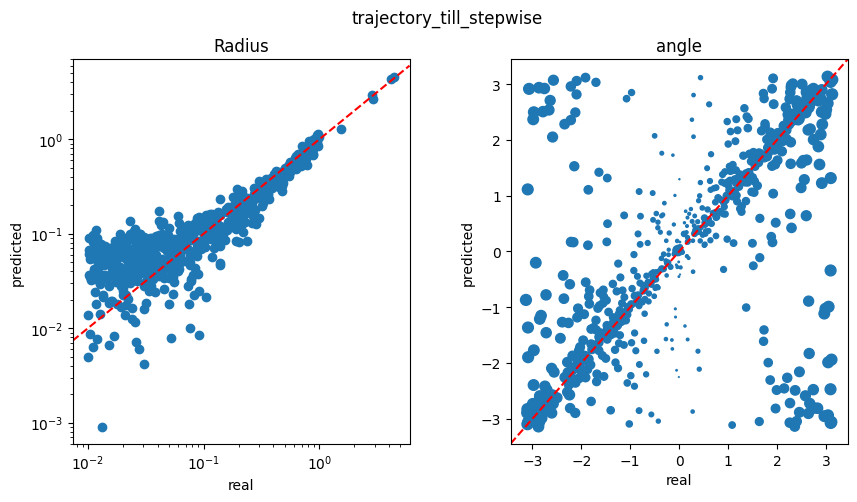

In [11]:
for result in results_list:
    trajectory_polar_comparison(result, result['name'])

In [12]:
colors=['r','g','b','y','m']
for result in results_list:
    plt_accuracy_results(result, result['name'],colors[results_list.index(result)])


def save_current_plot(name, location):
    os.makedirs(location, exist_ok=True)  # Make sure the directory exists

    png_path = os.path.join(location, f"{name}.png")
    plt.savefig(png_path)

    svg_path = os.path.join(location, f"{name}.svg")
    plt.savefig(svg_path)

plt.ylim(0,1)
plt.xlabel("step size [pixeln]")
plt.ylabel("error in procent [norm(error)/norm(step)]")
plt.xscale('log')
plt.legend()
save_current_plot("stepsize_accuracy", os.path.join(experiment_folder, experiment_name))

In [13]:
labels

['all_tra_corr_cleaned',
 'trajectory_gauss',
 'trajectory_mean',
 'trajectory_till',
 'trajectory_till_stepwise']

In [14]:
exposure_times = [25, 50, 100, 200]
results_list_list = []
labels = [
    "all_tra_corr",
    "all_tra_gauss",
    "all_tra_mean",
    "all_tra_till",
    "all_tra_till_stepwise",
]

for exposure_tiem in exposure_times:
    file_name = "exposure_" + str(exposure_tiem)
    exposure_folder = os.path.join(experiment_folder, file_name)
    results_list = []
    all_points = np.load(os.path.join(exposure_folder, "all_points.npy"))
    all_steps = calculate_steps(all_points)
    # Loop through each transformed trajectory
    trajectories = []
    for label in labels:
        tra = np.load(os.path.join(exposure_folder, label + ".npy"))
        trajectories.append(tra)
    trajectories[0]=correct_trajectory_with_gauss(trajectories[0], trajectories[1])
    transformed_trajectories = []
    for tra in trajectories:
        matrix = compute_transformation_matrix(calculate_steps(tra), all_steps)
        transformed_trajectories.append(reconstruct_trajecotry(calculate_steps(tra) @ matrix))



    all_points = np.load(os.path.join(exposure_folder, "all_points.npy"))
    
    for tra, label in zip(transformed_trajectories, labels):
        (
            Stepsize_bins,
            stepsize_bin_accuracies,
            sigma_stepsize_bin_accuracies,
        ) = compare_trajectories(tra, all_points)

        results = {
            "Stepsize_bins": Stepsize_bins,
            "stepsize_bin_accuracies": stepsize_bin_accuracies,
            "sigma_stepsize_bin_accuracies": sigma_stepsize_bin_accuracies,
            "test_traj": all_points,
            "calc_traj": tra,
            "name": label,
        }

        results_list.append(results)
    results_list_list.append(results_list)

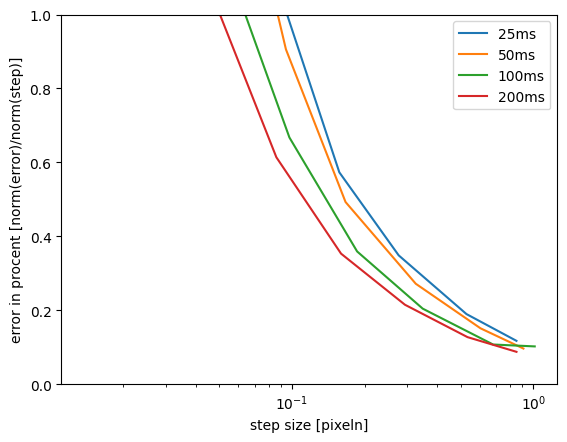

In [15]:
colors=['r','g','b','y','m']
for result_list, exposure_time in zip(results_list_list, exposure_times):
    Stepsize_bins=result_list[0]['Stepsize_bins']
    sorted_indices = np.argsort(Stepsize_bins, kind='mergesort')
    Stepsize_bins = np.array(Stepsize_bins)[sorted_indices]
    stepsize_bin_accuracies_list=[]
    for result in result_list:
        stepsize_bin_accuracies=result['stepsize_bin_accuracies']
        stepsize_bin_accuracies=np.array(stepsize_bin_accuracies)[sorted_indices]
        stepsize_bin_accuracies_list.append(stepsize_bin_accuracies)
    stepsize_bin_accuracies_list=np.array(stepsize_bin_accuracies_list)

    min_accuracies=np.min(stepsize_bin_accuracies_list,axis=0)

    plt.plot(Stepsize_bins[:-3],min_accuracies[:-3], label=str(exposure_time)+"ms")

plt.ylim(0,1)
plt.xlabel("step size [pixeln]")
plt.ylabel("error in procent [norm(error)/norm(step)]")
plt.xscale('log')
plt.legend()
